# **Predictive Analysis of Academic Performance Utilizing Study Habits and Prior Achievement Metrics**

In [1]:
# libraries needed in this proposal

library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## **Introduction**

#### **Relevant Background Information on the Topic**

The emergence of the digital age and web-based learning platforms has brought about a significant change in education. This transformation has opened up new possibilities for in-depth analysis of student engagement. In our study, we utilize the dataset provided by Kahraman et al. (2013) as a foundation, taking advantage of these technological advancements to explore various behavioral variables.

#### **The Question We Will Try to Answer with Our Project**

In our research, we aim to utilize the provided dataset to address two primary inquiries. Firstly, we investigate whether it is possible to predict a student’s knowledge level (UNS) by considering factors such as study time for material (STG), repetition number for material (SCG), study time for related objects like prerequisites (STR), exam performance for related objects (LPR), and exam performance for material (PEG). Secondly, we explore which combination of factors, specifically STG, SCG, STR, and LPR, exhibits the strongest correlation with PEG, the exam performance for the material under study.

#### **The Dataset Description That Will Be Used to Answer the Question**

The foundation of our study comprises a CSV dataset consisting of 258 entries. This dataset includes various variables that capture important aspects such as study time (STG), repetition number (SCG), study time for related objects (STR), exam performance for related objects (LPR), material exam performance (PEG), and user knowledge level (UNS). The selection of these variables is based on a course modeling approach developed by Cristea & Mooij (2003) in which learning resources for students are broken down into concept maps and linked concepts. These resources will guide our exploration into the determinants of academic performance in a digital learning context.

## **Methods & Results**

#### **Data preparation**
Initially, we imported the dataset we intend to use in our study into a csv format. Then, we uploaded this csv file into a dedicated remote repository for this project. In the code snippet below, we load the raw format of this csv formated content into this report.

In [2]:
# download data from our group's remote repository

url <- "https://raw.githubusercontent.com/stankur/dsci-100-project/main/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.csv"

data <- read_csv(url)

data <- data |> 
        select(STG:UNS)

data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


#### **Exploratory Data Analysis**
To gain insights into the data, we will perform an exploratory data analysis. This involves computing summary statistics, checking for missing values, and visualizing the distributions and relationships between variables using plots and charts. For an intuitive visualization of our findings, we'll leverage the 'ggpairs' function from the 'GGally' R package. This will enable a scatterplot matrix construction, offering a detailed insight into variable relationships and interactions. We will conduct a pairwise correlation analysis, in which if a variable is found to be highly correlated with another, we will remove one of these variables.


In [19]:
# Mean values of quantitative variables
mean_data <- data |>
                mutate(STG = mean(STG),  
                       SCG = mean(SCG), 
                       STR = mean(STR),
                       LPR = mean(LPR),
                       PEG = mean(PEG)) |>
                select(STG, SCG, STR, LPR, PEG) |>
                head(1)

# Checking for missing data
na <- data |> 
            mutate(STG = is.na(STG), SCG = is.na(SCG), 
                   STR = is.na(STR), LPR = is.na(LPR), 
                   PEG = is.na(PEG), UNS = is.na(UNS)) |>
            select(STG, SCG, STR, LPR, PEG, UNS) |>
            head(1)

# Summary of 'UNS' categorical variable
uns_grouped_by_level <- group_by(data, UNS) |>
                        summarize(count = n())

# Transforming data for reporting
mean_tidy <- mean_data |>
        pivot_longer(cols = STG:PEG,
                    names_to = "Feature", values_to = "Mean") 

na_tidy <- na |>
        pivot_longer(na, cols = STG:UNS,
                    names_to = "Feature", values_to = "NA")

tidy <- data.frame("Feature" = c("STG", "SCG", "STR", "LPR", "PEG", "UNS"),
                   "Mean" = c(0.3711473, 0.3556744, 0.4680039, 0.4327132, 0.4585388, "NA"),
                   "Is.NA" = c(FALSE, FALSE, FALSE, FALSE, FALSE, FALSE)) |>
        as_tibble(tidy)

tidy
uns_grouped_by_level

Warning message in gsub(vec_paste0("^", names_prefix), "", cols):
“argument 'pattern' has length > 1 and only the first element will be used”


Feature,Mean,Is.NA
<chr>,<chr>,<lgl>
STG,0.3711473,FALSE
SCG,0.3556744,FALSE
STR,0.4680039,FALSE
LPR,0.4327132,FALSE
PEG,0.4585388,FALSE
UNS,NA,FALSE


UNS,count
<chr>,<int>
High,63
Low,83
Middle,88
very_low,24


Our initial visualization consists of histograms illustrating the distribution of numerical variables (STG, SCG, STR, LPR, PEG), effectively revealing their range and frequency. Following this, we present a bar chart showcasing the distribution of categorical variable UNS (knowledge level), enabling a comparative analysis of each knowledge level category's frequency.

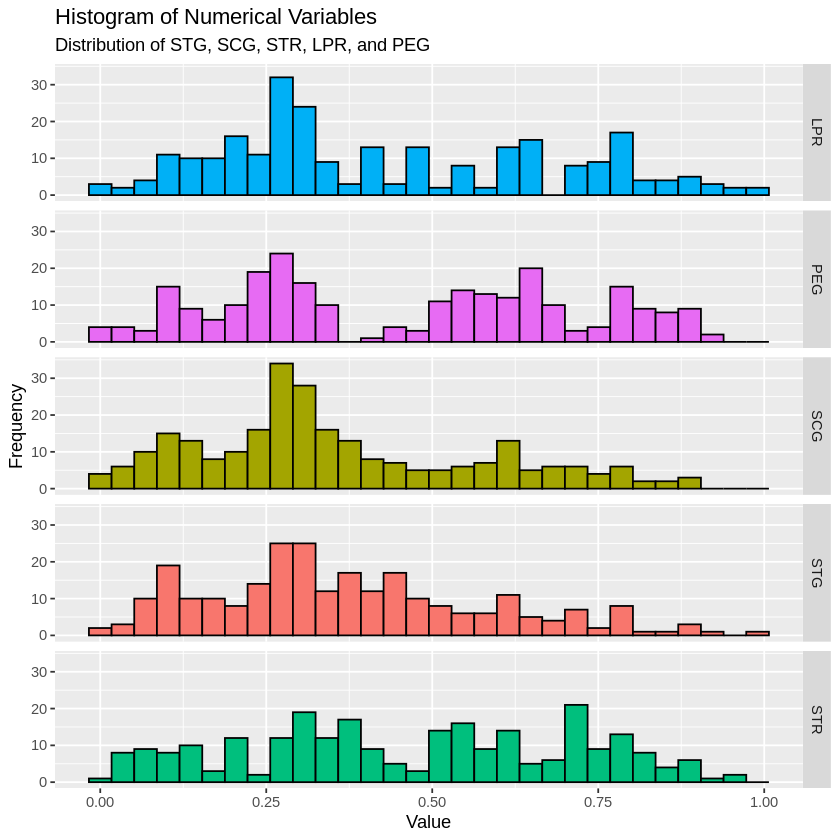

In [4]:
# Selecting numerical columns for visualization
histogrammable_data <- data |> select(STG:PEG)

# Reshaping the data from wide format to long format to facilitate visualization
histogrammable_data_pivoted <- pivot_longer(histogrammable_data, 
                                           cols= STG:PEG,
                                           names_to = "column_name",
                                           values_to ="value")

# Creating a histogram for each numerical variable
quantitative_plot <- ggplot(histogrammable_data_pivoted, aes(x = value, fill = as_factor(column_name))) +
        geom_histogram(bins = 30, color = "black") + 
        facet_grid(rows = vars(column_name)) +  
        labs(fill = "Variable", x = "Value", y = "Frequency", 
             title = "Histogram of Numerical Variables", 
             subtitle = "Distribution of STG, SCG, STR, LPR, and PEG") +
        theme(legend.position = "none") 

quantitative_plot

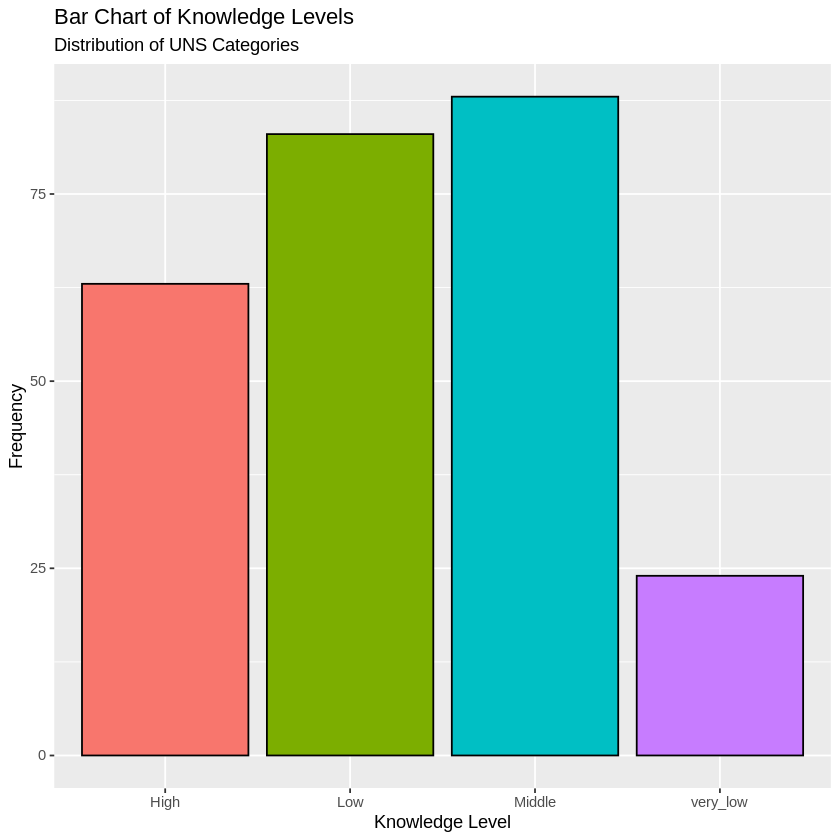

In [5]:
# Organize categories in descending order
uns_grouped_by_level <- uns_grouped_by_level |> 
                        mutate(UNS = factor(UNS, levels = names(sort(table(UNS), decreasing = TRUE))))

# Create bar chart for the categorical variable 'UNS'
uns_bar <- ggplot(uns_grouped_by_level, aes(x=UNS, y=count, fill=UNS)) + 
        geom_bar(stat="identity", color="black") + 
        labs(x="Knowledge Level", 
             y="Frequency", 
             title = "Bar Chart of Knowledge Levels", 
             subtitle = "Distribution of UNS Categories", 
             fill="Knowledge Level") +
        theme(legend.position = "none")

uns_bar

In the following code snippet, we utilize ggpairs to visualize the pairwise relationship between every possible pair of numerical variables present in our dataset.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



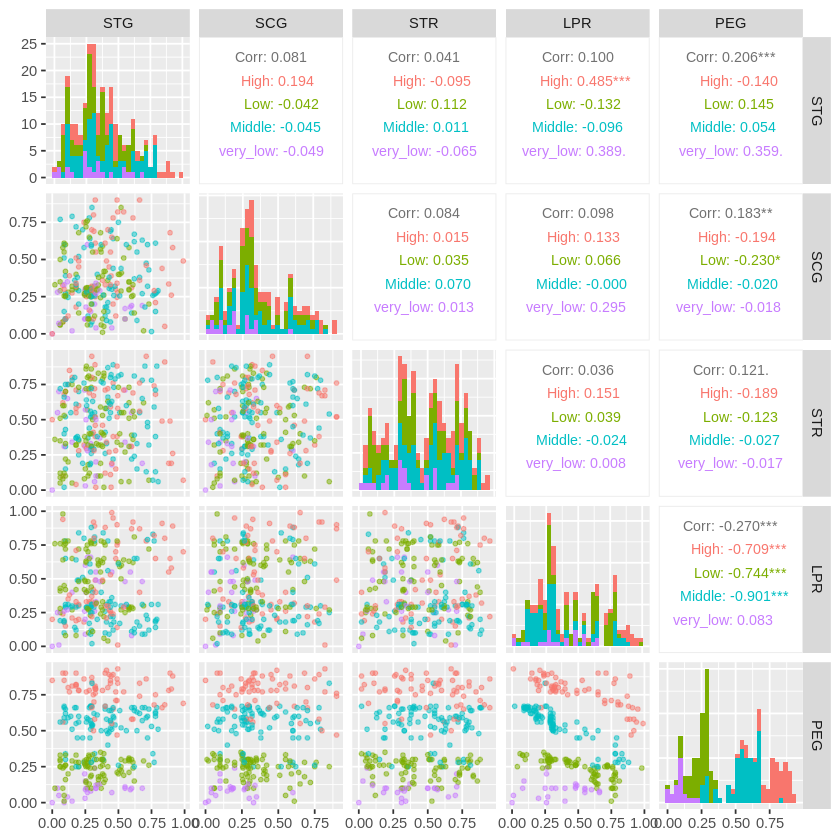

In [6]:
# Select numerical columns for visualization
data_for_ggpairs <- data |> select(STG:PEG)

# Create a pairs plot with ggpairs() function
pairs_plot <- ggpairs(data_for_ggpairs, 
                      mapping = ggplot2::aes(color = data$UNS),
                      upper = list(continuous = wrap("cor", size = 3)),  # display correlation on the upper part
                      diag = list(continuous = wrap("barDiag")),  # display histogram on the diagonal
                      lower = list(continuous = wrap("points", alpha = 0.5, size = 1)))  # display scatterplot on the lower part

# Print the plot
print(pairs_plot)

#### **Model Selection and Training**
We selected the K-Nearest Neighbors (KNN) algorithm and linear regression to address the research questions. 

#### **Model Evaluation**
To evaluate the performance of the models, we will use appropriate metrics depending on the task. For UNS, we will compute classification metrics such as accuracy. Cross-validation will be used to assess the performance and generalizability of our model. For predicting PEG, we will utilize the regression metric $RMSE$.

$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$

$\text{RMSE}$ / $\text{RMSPE}$ takes the squared difference between each observed value $y_i$ and its corresponding predicted value $\hat{y}_i$, sums up all these squared differences, divides by the total number of observations $n$, and then takes the square root of the result. Since it squares the differences, it is sensitive to outliers reflecting their influence on the model’s accuracy.


In [7]:
# Set seed for reproducibility
set.seed(9999)

# Split the data
data_split <- initial_split(data, prop = 0.75, strata = UNS)
data_train <- training(data_split)
data_test <- testing(data_split)


In [8]:
lm_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")


predictor_names <- c("STG", "SCG", "STR", "LPR")

results <- tibble(model_string = character(), rmpse = double(), rmse = double())

# Generate power set of predictors excluding the empty set
predictor_combinations <- unlist(lapply(seq_along(predictor_names), function(x) combn(predictor_names, x, simplify = FALSE)), recursive = FALSE)

# For every combination of predictors
for (predictors in predictor_combinations) {
  # Create a model string for this combination of predictors
  model_string <- paste("PEG", "~", paste(predictors, collapse="+"))

  # Create a recipe from the model string
    lm_recipe <- recipe(as.formula(model_string), data = data_train)
    
    data_fit <- workflow() |>
                add_model(lm_spec) |>
                add_recipe(lm_recipe) |>
                fit(data_train)
    
    lm_rmse <- data_fit |>
             predict(data_train) |>
             bind_cols(data_train) |>
             metrics(truth = PEG, estimate = .pred) |>
             filter(.metric == "rmse") |>
             select(.estimate) |>
             pull()

    lm_rmspe <- data_fit |>
             predict(data_test) |>
             bind_cols(data_test) |>
             metrics(truth = PEG, estimate = .pred) |>
             filter(.metric == "rmse") |>
             select(.estimate) |>
             pull()

# Add these results to the dataframe
results <- results |> add_row(model_string = model_string, rmpse = lm_rmspe, rmse = lm_rmse)
}

results <- results |>
    arrange(rmpse) |>
    head(5)
                                        
results                                    

model_string,rmpse,rmse
<chr>,<dbl>,<dbl>
PEG ~ STG+STR+LPR,0.2301470,0.2383084
PEG ~ STG+SCG+STR+LPR,0.2328443,0.2314009
PEG ~ STG+LPR,0.2348830,0.2390986
PEG ~ STG+SCG+LPR,0.2365284,0.2318815
PEG ~ STR+LPR,0.2394338,0.2448710


In [ ]:
# A plot for the first model                                        
first_lm_recipe <- recipe(PEG ~ STG + STR + LPR, data = data_test)
                                        
first_lm_fit <- workflow() |>
                add_recipe(first_lm_recipe) |>
                add_model(lm_spec) |>
                fit(data = data_test)
                                
                                        
first_plot <- first_lm_fit |>
             predict(data_test) |>
             bind_cols(data_test) |>
             ggplot(aes(x = PEG, y = .pred)) +
             geom_point() +
             geom_smooth(method = "lm", se = FALSE) +
             labs(x = "PEG" , y = "Predicted PEG", title = "PEG prediction based on STG+STR+LPR")
                         
first_plot
                                        
                                        
# A plot for the second model                                        
second_lm_recipe <- recipe(PEG ~ STG + SCG + STR + LPR, data = data_test)
                                        
second_lm_fit <- workflow() |>
                add_recipe(second_lm_recipe) |>
                add_model(lm_spec) |>
                fit(data = data_test)
                                
                                        
second_plot <- second_lm_fit |>
             predict(data_test) |>
             bind_cols(data_test) |>
             ggplot(aes(x = PEG, y = .pred)) +
             geom_point() +
             geom_smooth(method = "lm", se = FALSE) +
             labs(x = "PEG" , y = "Predicted PEG", title = "PEG prediction based on STG+SCG+STR+LPR")
                                        
second_plot

# A plot for the thrid model                                        
third_lm_recipe <- recipe(PEG ~ STG + LPR, data = data_test)
                                        
third_lm_fit <- workflow() |>
                add_recipe(third_lm_recipe) |>
                add_model(lm_spec) |>
                fit(data = data_test)
                                
                                        
third_plot <- third_lm_fit |>
             predict(data_test) |>
             bind_cols(data_test) |>
             ggplot(aes(x = PEG, y = .pred)) +
             geom_point() +
             # geom_smooth(method = "lm", se = FALSE) +
             labs(x = "PEG" , y = "Predicted PEG", title = "PEG prediction based on STG+LPR")
                         
third_plot
                                        
                                        
# A plot for the fourth model                                        
fourth_lm_recipe <- recipe(PEG ~ STG + SCG + LPR, data = data_test)
                                        
fourth_lm_fit <- workflow() |>
                add_recipe(fourth_lm_recipe) |>
                add_model(lm_spec) |>
                fit(data = data_test)
                                
                                        
fourth_plot <- fourth_lm_fit |>
             predict(data_test) |>
             bind_cols(data_test) |>
             ggplot(aes(x = PEG, y = .pred)) +
             geom_point() +
             # geom_smooth(method = "lm", se = FALSE) +
             labs(x = "PEG" , y = "Predicted PEG", title = "PEG prediction based on STG+SCG+LPR")
                                        
fourth_plot

# A plot for the fifth model                                        
fifth_lm_recipe <- recipe(PEG ~ STR + LPR, data = data_test)
                                        
fifth_lm_fit <- workflow() |>
                add_recipe(fifth_lm_recipe) |>
                add_model(lm_spec) |>
                fit(data = data_test)
                                
                                        
fifth_plot <- fifth_lm_fit |>
             predict(data_test) |>
             bind_cols(data_test) |>
             ggplot(aes(x = PEG, y = .pred)) +
             geom_point() +
             # geom_smooth(method = "lm", se = FALSE) +
             labs(x = "PEG" , y = "Predicted PEG", title = "PEG prediction based on STR+LPR")
                                        
fifth_plot

In [ ]:

# Define names of the predictors
predictor_names <- c("STG", "SCG", "STR", "LPR", "PEG")

# Create an empty tibble to store the results
results <- tibble(model_string = character(), best_k = integer(), best_accuracy = numeric())

# Create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Generate power set of predictors excluding the empty set
predictor_combinations <- unlist(lapply(seq_along(predictor_names), function(x) combn(predictor_names, x, simplify = FALSE)), recursive = FALSE)

# For every combination of predictors
for (predictors in predictor_combinations) {
  # Create a model string for this combination of predictors
  model_string <- paste("UNS", "~", paste(predictors, collapse="+"))

  # Create a recipe from the model string
  data_recipe <- recipe(as.formula(model_string), data = data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

  # Tune the KNN classifier with these predictors
  tuning_results <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = data_vfold, grid = tibble(neighbors = 1:100)) |>
    collect_metrics()

  best_k_and_accuracy <- tuning_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1)

best_k <- as.integer(best_k_and_accuracy$neighbors[1])  # convert to integer
best_accuracy <- best_k_and_accuracy$mean[1]

# Add these results to the dataframe
results <- results |> add_row(model_string = model_string, best_k = best_k, best_accuracy = best_accuracy)
}

# Sort the results by accuracy in descending order
results <- results |> arrange(desc(best_accuracy))

# Print the sorted results
print(results)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "SCG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "SCG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 5, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 150, by = 10))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
# Set seed for reproducibility
set.seed(9999)

# Define the first model
model_string <- "STG+STR+LPR+PEG"

# Create a formula for this model
model_formula <- as.formula(paste("UNS ~", model_string))

# Create a recipe from the model formula
data_recipe <- recipe(model_formula, data = data_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Define a KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a 10-fold cross-validation object
data_vfold <- vfold_cv(data_train, v = 10, strata = UNS)

# Define a grid of K values
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# Tune the KNN model with this recipe
knn_results <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

# Filter the results for accuracy
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Find the K value with the highest mean accuracy
best_accuracy <- accuracies |>
  arrange(desc(mean)) |>
  slice(1)

# Print the best K value and accuracy
print(paste("Model:", model_string))
print(paste("Best K:", best_accuracy$neighbors))
print(paste("Best accuracy:", best_accuracy$mean))

# Create a plot of accuracy vs K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate",
       title = paste("Model:", model_string)) +
  theme(text = element_text(size = 12))

# Print the plot
print(accuracy_vs_k)

In [ ]:
set.seed(9999)
# Classification: predicting UNS

data <- data |> 
    mutate(UNS = as.factor(UNS))

# Splitting the data
data_split <- initial_split(data, prop = 0.75, strata = UNS)
data_train <- training(data_split)
data_test <- testing(data_split)
              



# Train data
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
            set_engine("kknn") |>
            set_mode("classification")

data_recipe <- recipe(UNS ~ LPR + PEG, data = data_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())


data_fit <- workflow() |>
            add_model(knn_spec) |>
            add_recipe(data_recipe) |>
            fit(data = data_train)



# Predict the class labels for our test set
data_test_predictions <- predict(data_fit, data_test) |> bind_cols(data_test)

# Compute the classifier's accuracy
data_test_prediction_accuracy <- data_test_predictions |>
                            metrics(truth = "UNS", estimate = ".pred_class") |> 
                            filter(.metric == "accuracy")
print(data_test_prediction_accuracy)

# Table of predicted labels and correct labels
data_conf_mat <- conf_mat(data_test_predictions, truth = "UNS", estimate = ".pred_class")
print(data_conf_mat)

new_seed <- tibble(LPR = 0.5, PEG = 0.8)

prediction <- predict(data_fit, new_seed)
print(prediction)

## **Results and interpretation**
After training and evaluating the models, we interpreted the results to answer the research questions. We analyzed the accuracy of predicting UNS and explored the relationships between the factors and PEG. Our findings including any significant insights or observations discovered during the analysis will be represented in the discussion section.


## **Discussion**
The most influential combination of variables for predicting the PEG is STG, STR, and LPR because, for this combination of factors, the lowest RMSPE was calculated. A significant relationship, however, has not been found between these variables and PEG based on the scatter plot. 
The single variable that is most positively correlated with PEG is STG with a correlation coefficient of 0.206, representing a weak positive linear relationship. We also found a weak negative correlation between LPR and PEG with a correlation coefficient of -0.270.


#### **Compared to Our Expectations**

Regarding the relationships between factors and exam performance for material (PEG), our expectations were also not entirely met. We expected to find stronger relationships between the factors and PEG, with a particular emphasis on the association between LPR and PEG. However, our analysis showed that study time for material (STG) and PEG had the strongest relationship, while LPR and PEG exhibited a negative correlation coefficient.
		
Since there is not a significant relationship, we tried to deduce what might be a possible explanation for the lack of strength in the relationship. We hypothesized that our chosen variables might not be a great reflection of the quality of study done by users of the education platform. 

A survey was conducted among accounting students by Davidson, R. A. (2002). The data were analyzed to identify any correlations or patterns between study approaches and exam performance. The findings of the study indicate a significant relationship between study approach and exam performance, specifically highlighting the association between deep study approaches and high exam performances.

This suggests a gap in the assumptions made in our study. We have not considered the intensity or study approach undertaken by the different students, hence, we were not able to capture a possibly significant dimension. In terms of study time, STG and STR, people who have studied deeply may have decided to study high leverage materials, such as attempting to answer more advanced and complex questions while spending less time relative to others. This means that low STG and STR might be able to be accompanied by a high PEG. Therefore, we postulate that one possible reason that the results showed there is a relationship between PEG and a combination of LPR, STG, and STR, but not a strong relationship, is that a deep study method is often accompanied by high LPR, STG, and STR, but it is the method that is not directly influencing the PEG, instead of these variables which might simply be accompanied effects of the study approach.

#### **Implications of Findings**

Unexpected findings offer interesting insights into the dynamics of the factors influencing student performance. 

Considering that the most influential combination for predicting exam performance is STG, STR, and LPR, study platforms could try to maximize these variables amongst their users, such as providing experience points or creating leaderboards that provide an incentive for users to optimize these factors.

 Based on this, study platform developers when allocating a budget for improving their respective platforms might give more weight or priority to improving or accommodating these three variables in order to improve exam performance. 


#### **Future Research Questions**

Based on the results indicating that factors have a slight relationship to PEG and building upon Davidson, R. A. 's (2002) research, which emphasized the relationship between study approach and exam performance, we suggest the exploration of potential strategies or educational interventions that can improve exam performance. 

A possibility would be to understand what factors influence a student’s approach to studying deeply. This would involve exploring a different variety of variables and understanding how these relate to a deep study approach. For instance, a possible variable of interest might be the time by which education material tabs are placed in an active frame to reduce noise from tab switching. 

Additionally, future research could explore the impact of external factors on exam performance. Factors such as sleep quality, stress levels, or environmental conditions during studying might influence students' cognitive functioning and subsequently affect their performance. Investigating the interaction between these external factors and the studied variables could provide a more comprehensive understanding of the determinants of exam performance.



## **Expected Outcomes and Significance**

#### **Expected Findings**

We hypothesize that the variables we have chosen for our models significantly influence the user knowledge level, and consequently, anticipate that our predictive model will have a high degree of accuracy. Moreover, we postulate that the 'LPR' variable, representing the repetition number for the material, will exhibit the most potent influence on exam performance, represented by the 'PEG' variable.

#### **Implications of Findings**

The implications of our anticipated findings are multifold. Primarily, they can guide the development of effective study strategies for students. For instance, if a strong relationship is observed between 'LPR' and 'PEG', it could recommend an emphasis on repetitive learning of basic subject material.

#### **Future Research Questions**

Our study could pave the way for several interesting research questions, including:

- How can the web learning system be optimized to promote superior knowledge growth among users?
- Which metrics (e.g., repetition or study time) should be emphasized for improved learning outcomes?
- Which type of study material (e.g., goal-oriented or related materials) holds the most promise for academic achievement?


## **Reference**

Kahraman, H. T., Sagiroglu, S., & Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of domain dependent data. Knowledge-Based Systems, 37, 283-295. https://doi.org/10.1016/j.knosys.2012.08.009


*need at least one more citation